<a href="https://colab.research.google.com/github/tejasoverhere/FER/blob/main/Assemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Apr 28 00:19:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from keras.models import model_from_json
import numpy as np
import cv2
import argparse
import os

In [3]:
import tensorflow as tf
import keras as keras
from imblearn.over_sampling import RandomOverSampler

from IPython.display import clear_output 



from tensorflow.python.saved_model.signature_def_utils_impl import build_signature_def, predict_signature_def
from tensorflow.python.saved_model import tag_constants, signature_constants
from tensorflow.python.saved_model import builder as saved_model_builder
from tensorflow.python.saved_model import utils

from keras.layers import Dense, Dropout, Input, MaxPool2D, Flatten, UpSampling2D
from keras.layers import Dense, Dropout, Input, MaxPool2D, Flatten, Convolution2D,BatchNormalization,Activation,MaxPooling2D
from keras.models import Model
from keras.models import Sequential
from keras.callbacks import History 

from keras import backend as K
# from keras.applications.InceptionV3 import InceptionV3
from keras.optimizers import adam_v2
from keras.utils import np_utils

import numpy as np
import pandas as pd

import random



In [4]:
#Connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#Unzip fer_csvs zip file to main repository
#Used a zip file because I was experiencing loss of data
!unzip drive/MyDrive/FER_csv/fer_csvs.zip

Archive:  drive/MyDrive/FER_csv/fer_csvs.zip
  inflating: README                  
  inflating: example_submission.csv  
  inflating: fer2013.bib             
  inflating: test.csv                
  inflating: train.csv               
  inflating: fer2013.csv             
  inflating: fer2013.tar.gz          
  inflating: icml_face_data.csv      


In [6]:



def df_column_to_list(df):
    list = [elem[0] for elem in df.values.tolist()]
    return list

def process_data(emotion,pixels, img_size=48):
    """
    Create labels and convert the grayscale image from a 1-D array of size 2304 to 2-D array of 48*48
    """   
    skip = ()
    pixels_list = df_column_to_list(pixels)

    np_images = []
    for index, item in enumerate(pixels_list):
        # 48x48
        data = np.zeros(img_size* img_size, dtype=np.uint8)
        pixel_data = item.split()
        if len(pixel_data) != 2304:
          skip.add(index)
          # print(index)
        else:
          data = pixel_data
          data = np.reshape(data,(48,48))

          np_images.append(np.array(data))

    np_images = np.array(np_images)
    # convert to float and divide by 255
    np_images = np_images.astype('float32') / 255.0


    emotions_list = df_column_to_list(emotion)
    y_data = []
    for index in range(len(emotions_list)):
        if index not in skip:
          y_data.append(emotions_list[index])

    # get labels
    labels = np_utils.to_categorical(y_data, 7)
    return [np_images,labels]

def process_data2(emotion,pixels, img_size=48):
    """
    Create labels and convert the grayscale image from a 1-D array of size 2304 to 2-D array of 48*48
    """   
    skip = []
    pixels_list = df_column_to_list(pixels)

    np_images = []
    for index, item in enumerate(pixels_list):
        # 48x48
        data = np.zeros(img_size* img_size, dtype=np.uint8)
        pixel_data = item.split()
        if len(pixel_data) != 2304:
          skip.append(Index)
          # print(index)
        else:
          data = pixel_data
          data = np.reshape(data,(48,48))

          np_images.append(np.array(data))

    np_images = np.array(np_images)
    # convert to float and divide by 255
    # np_images = np_images.astype('float32') / 255.0


    emotions_list = df_column_to_list(emotion)
    y_data = []
    for index in range(len(emotions_list)):
        if index not in skip:
          y_data.append(emotions_list[index])

    # get labels
    labels = np_utils.to_categorical(y_data, 7)
    return [np_images,labels]

def process_data3(emotion,pixels, img_size=48):
    """
    Create labels and convert the grayscale image from a 1-D array of size 2304 to 2-D array of 48*48
    """   
    skip = []
    pixels_list = pixels.tolist()

    np_images = []
    for index, item in enumerate(pixels_list):
        # 48x48
        # if index ==1:
        #   print(len(item[0].split()))
        data = np.zeros(img_size* img_size, dtype=np.uint8)
        pixel_data = item[0].split()
        if len(pixel_data) != 2304:
          skip.append(Index)
          # print(index)
        else:
          data = pixel_data
          data = np.reshape(data,(48,48))

          np_images.append(np.array(data))

    np_images = np.array(np_images)
    # convert to float and divide by 255
    # np_images = np_images.astype('float32') / 255.0


    emotions_list = emotion.tolist()
    y_data = []
    for index in range(len(emotions_list)):
        if index not in skip:
          y_data.append(emotions_list[index])

    # get labels
    labels = np_utils.to_categorical(y_data, 7)
    return [np_images,labels]


def add_occlusion(image):

    
    kernels = [[range(10,17),range(18,36)],
               [range(25,32),range(18,36)],
               [range(14,27),range(8,16)],
               [range(14,27),range(22,30)],
               [range(5,12),range(18,36)],
               [range(20,27),range(18,36)],
               [range(9,22),range(8,16)],
               [range(9,22),range(22,30)],
               [range(10,17),range(13,31)],
               [range(25,32),range(13,31)],
               [range(14,27),range(13,21)],
               [range(14,27),range(17,25)]]
              #  [range(14,27),range(8,30)],
              #  [range(10,32),range(18,36)],
              #  [range(25,32),range(18,36)],
              #  [range(14,27),range(18,24)],
              # #  [range(14,27),range(22,30)],
              #  [range(17,24),range(15,35)]]
    x = random.randint(1,len(kernels)*2)
    # print(image)
    image_new = image.copy()
    if x <= len(kernels):
        return image_new
    else:
        kernel = kernels[x-len(kernels)-1]
        # kernel_x = kernel[0][-1]-kernel[0][0]
        # kernel_y = kernel[1][-1]-kernel[1][0]
        # print(x,kernel_x,kernel_y)
        image_new[kernel[0][0]:kernel[0][-1],kernel[1][0]:kernel[1][-1],0] = 0
        # image_new[kernel[0][0]:kernel[0][-1],kernel[1][0]:kernel[1][-1],1] = 0
        # image_new[kernel[0][0]:kernel[0][-1],kernel[1][0]:kernel[1][-1],2] = 0
        # image_new[kernel[0][0]:kernel[0][-1],kernel[1][0]:kernel[1][-1],0] = 128
        # image_new[kernel[0][0]:kernel[0][-1],kernel[1][0]:kernel[1][-1],1] = 128
        # image_new[kernel[0][0]:kernel[0][-1],kernel[1][0]:kernel[1][-1],2] = 128
    return image_new

def split_for_test(data):
    train = data[0:28708]
    test = data[28709:]
    return train, test

def get_feature_map(vgg16, array_input, n_feature_maps):
  #Duplicate greyscale image to three channels for vgg input
    vg_input = np.empty([n_feature_maps, 48, 48, 3])
    for index, item in enumerate(vg_input):
        item[:, :, 0] = array_input[index]
        item[:, :, 1] = array_input[index]
        item[:, :, 2] = array_input[index]

  #Use predict to get the feature map based on imagenet weights, it's an 
    features = vgg16.predict(vg_input)
    del (vg_input)

  #rearrange feature map
    feature_map = np.empty([n_feature_maps, 512])
    for idx_pic, picture in enumerate(features):
        feature_map[idx_pic] = picture
    return feature_map



In [7]:
from numpy.ma.core import ptp

# Get session/graph data from keras
K.set_learning_phase(0)

#Fetch data
raw_data = pd.read_csv('fer2013.csv')

#Separate data and labels

# raw_data_train = raw_data[raw_data['Usage'] == 'Training']
raw_data_public = raw_data[raw_data['Usage'] == 'PublicTest']
raw_data_private = raw_data_private = raw_data[raw_data['Usage'] == 'PrivateTest']

# y = raw_data_train.emotion
# X = raw_data_train.pixels







/usr/local/lib/python3.7/dist-packages/keras/backend.py:450: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


In [8]:
[x_test_matrix,y_test] = process_data2(raw_data_private[['emotion']],raw_data_private[['pixels']])
[x_valid_matrix,y_valid] = process_data2(raw_data_public[['emotion']],raw_data_public[['pixels']])

In [ ]:
del(X)
del(y)

NameError: ignored

In [9]:
# n_train = int(len(X_train))
n_valid = int(len(x_valid_matrix))
n_test = int(len(x_test_matrix))

#Convert to 3 channels for these architectures
# x_train_input = np.empty([n_train, 48, 48, 1])
# for index, item in enumerate(x_train_input):
#     item[:, :, 0] = X_train[index]
#     # gray = cv2.cvtColor(X_train[index], cv2.COLOR_RGB2GRAY)
#     # gray = X_train[index].astype(np.uint16)
#     # eq = clahe.apply(gray)
#     # item[:, :, 0] = eq

# x_valid_input = np.empty([n_valid, 48, 48, 1])
# for index, item in enumerate(x_valid_input):
#     item[:, :, 0] = x_valid_matrix[index]

x_test_input = np.empty([n_test, 48, 48, 1])
for index, item in enumerate(x_test_input):
    item[:, :, 0] = x_test_matrix[index]



In [ ]:
type(x_test_input)

In [ ]:
x_test_input =tf.expand_dims(x_test_matrix, -1)

In [ ]:
x_test_input_3 = tf.repeat(x_test_input,3,-1)

In [ ]:
x_test_input_3.shape

TensorShape([3589, 48, 48, 3])

In [ ]:
from google.colab.patches import cv2_imshow

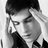

True

In [ ]:
cv2_imshow(x_test_input[2])
cv2.imwrite('/content/drive/MyDrive/OccImages/original.jpg',x_test_input[2])

In [ ]:
a = tf.convert_to_tensor(x_test_input)

In [ ]:
a.shape.as_list()[1:3]

NameError: ignored

In [ ]:
b = np.ones(a.shape)

In [ ]:
b.shape

(3589, 48, 48, 1)

In [ ]:
b[:,10:40,10:30,0]=0

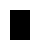

In [ ]:
cv2_imshow(b[1]*255.0)

In [ ]:
c = tf.convert_to_tensor(b)

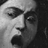

In [ ]:
cv2_imshow(a.numpy()[4])

In [ ]:
d = tf.multiply(a,c)

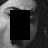

In [ ]:
cv2_imshow(d.numpy()[4])

In [ ]:
def occlusion_layer(tensor):
  # if random.randint(1,2) == 1:
  #   return tensor
  shape = tensor.shape.as_list()[1:3]
  center_x = shape[0]/2
  center_y = shape[1]/2
  #Keep it in the center
  x = random.randint(center_x/2,center_x+center_x/2)
  y = random.randint(center_y/2,center_y+center_y/2)
  #Draw bounding boxes of atleast len 4, and max center/2
  l = random.randint(4,center_x/2)
  b = random.randint(4,center_y/2)
  mask = np.ones(tensor.shape)
  mask[:,(int)(x-l/2):(int)(x+l/2),(int)(y-b/2):(int)(y+b/2),0] = 0
  print()
  return tf.multiply(tensor,tf.convert_to_tensor(mask))

In [10]:
class OcclusionLayer(tf.keras.layers.Layer):
  def __init__(self):
      super(OcclusionLayer, self).__init__()

  def call(self, tensor):
    if random.randint(1,2) == 1 or len(tensor.shape.as_list())!=4 or None in tensor.shape.as_list():
      return tensor
    shape = tensor.shape.as_list()[1:3]
    center_x = (int)(shape[0]/2)
    center_y = (int)(shape[1]/2)
    x = random.randint(1,center_x)
    y = random.randint(1,center_y)
    l = random.randint(2,(int)(center_x/2))
    b = random.randint(2,(int)(center_y/2))
    m = np.ones(tensor.shape)
    m[:,(int)(x-l/2):(int)(x+l/2),(int)(y-b/2):(int)(y+b/2),0] = 0
    return tf.multiply(tensor,tf.convert_to_tensor(m,dtype=tensor.dtype))

In [11]:
class OcclusionLayerThree(tf.keras.layers.Layer):
  def __init__(self):
      super(OcclusionLayerThree, self).__init__()

  def call(self, tensor):
    if random.randint(1,2) == 1 or len(tensor.shape.as_list())!=4 or None in tensor.shape.as_list():
      return tensor
    shape = tensor.shape.as_list()[1:3]
    center_x = (int)(shape[0]/2)
    center_y = (int)(shape[1]/2)
    x = random.randint(1,center_x)
    y = random.randint(1,center_y)
    l = random.randint(2,(int)(center_x/2))
    b = random.randint(2,(int)(center_y/2))
    m = np.ones(tensor.shape)
    m[:,(int)(x-l/2):(int)(x+l/2),(int)(y-b/2):(int)(y+b/2),0] = 0
    m[:,(int)(x-l/2):(int)(x+l/2),(int)(y-b/2):(int)(y+b/2),1] = 0
    m[:,(int)(x-l/2):(int)(x+l/2),(int)(y-b/2):(int)(y+b/2),2] = 0
    return tf.multiply(tensor,tf.convert_to_tensor(m,dtype=tensor.dtype))

In [ ]:
# k = 0
for i in range(100):
  new = occlusion_layer(a)
  cv2_imshow(new.numpy()[2])
  cv2.imwrite('/content/drive/MyDrive/OccImages/new'+str(i)+'.jpg',new.numpy()[2])
# k= k+1

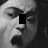

In [12]:
import seaborn as sn
import matplotlib.pyplot as plt

def draw_plots(model_history):
  #Plot training and validation losses over one another
  plt.plot(model_history.history['loss'], label='train loss')
  plt.plot(model_history.history['val_loss'], label='val loss')
  plt.legend()
  plt.xlabel('epochs') 
  plt.ylabel('Categorical Crossentropy loss') 
  plt.show()
  plt.savefig('LossVal_loss')

  #Plot training and validation accuracies over one another
  plt.plot(model_history.history['accuracy'], label='train acc')
  plt.plot(model_history.history['val_accuracy'], label='val acc')
  plt.legend()
  plt.xlabel('epochs') 
  plt.ylabel('Accuracy') 
  plt.show()
  plt.savefig('AccVal_acc')

  #Plot training and validation losses over one another
  plt.plot(model_history.history['loss'], label='train loss')
  plt.plot(model_history.history['accuracy'], label='train acc')
  plt.xlabel('epochs') 
  plt.ylabel('Value') 
  plt.legend()
  plt.show()
  plt.savefig('LossVal_loss')

def draw_confusion_matrix(res,y_test):
  correct = 0
  y_true = []
  y_pred = []
  classes = ['angry','disgust','fear','happy','sad','surprise','neutral']

  for i in range(len(res)):
    a = res[i]
    y_pred.append(np.argmax(a))
    b = y_test[i]
    y_true.append(np.argmax(b))
    if np.argmax(a) == np.argmax(b):
      correct+=1

  total = len(y_test)

  #in case anything is float
  y_pred = [int(i) for i in y_pred]
  y_true = [int(i) for i in y_true]

  final = np.zeros((7, 7)).tolist()
  #Calculate the confusion matrix values by incrementing at the row of the original label and what was predicted
  for i in range(len(y_true)):
      a = y_true[i]
      b = y_pred[i]
      final[a][b] = final[a][b] + 1

  #Calculates as a percentage
  final2 = np.zeros((7, 7)).tolist()
  for i in range(len(final2)):
      for j in range(len(final2[i])):
        final2[i][j] = final[i][j]/sum(final[i])*100
      # count= collections.Counter(final[a])


  df = pd.DataFrame(final, range(7), range(7))
  sn.set(font_scale=1.4) 
  sn.heatmap(df, annot=True, annot_kws={"size": 12}, xticklabels=classes, yticklabels=classes,
              cmap="Blues", fmt='g') 

  plt.title("Confusion matrix on " + str(total) + " images \n (No. of correct predictions)")
  plt.show()

  df2 = pd.DataFrame(final2, range(7), range(7))
  sn.set(font_scale=1.4)  
  sn.heatmap(df2, annot=True, annot_kws={"size": 10}, xticklabels=classes, yticklabels=classes,
              cmap="Blues", fmt='.4g') 

  plt.title("Confusion matrix on " + str(total) + " images \n (Percentage of correct classifications)")
  plt.show()



  print('\n\nAccuracy of the network on the ' + str(total) + ' data: %.2f %%' % (100 * correct / total))
  return float(100 * float(correct / total))


def draw_confusion_matrix2(res,y_test):
  correct = 0
  y_true = []
  y_pred = []
  classes = ['angry','disgust','fear','happy','sad','surprise','neutral']
  true_dict = {}
  pred_dict = {}
  for i in range(len(res)):
    a = res[i]
    y_pred.append(np.argmax(a))
    b = y_test[i]
    y_true.append(np.argmax(b))
    if np.argmax(a) == np.argmax(b):
      correct+=1
      true_dict[np.argmax(a)]+=1
      pred_dict[np.argmax(b)]+=1

  total = len(y_test)

  #in case anything is float
  y_pred = [int(i) for i in y_pred]
  y_true = [int(i) for i in y_true]

  final = np.zeros((7, 7)).tolist()
  #Calculate the confusion matrix values by incrementing at the row of the original label and what was predicted
  for i in range(len(y_true)):
      a = y_true[i]
      b = y_pred[i]
      final[a][b] = final[a][b] + 1

  #Calculates as a percentage
  final2 = np.zeros((7, 7)).tolist()
  for i in range(len(final2)):
      for j in range(len(final2[i])):
        final2[i][j] = final[i][j]/sum(final[i])*100
      # count= collections.Counter(final[a])


  df = pd.DataFrame(final, range(7), range(7))
  sn.set(font_scale=1.4) 
  sn.heatmap(df, annot=True, annot_kws={"size": 12}, xticklabels=classes, yticklabels=classes,
              cmap="Blues", fmt='g') 

  plt.title("Confusion matrix on " + str(total) + " images \n (No. of correct predictions)")
  plt.show()

  df2 = pd.DataFrame(final2, range(7), range(7))
  sn.set(font_scale=1.4)  
  sn.heatmap(df2, annot=True, annot_kws={"size": 10}, xticklabels=classes, yticklabels=classes,
              cmap="Blues", fmt='.4g') 

  plt.title("Confusion matrix on " + str(total) + " images \n (Percentage of correct classifications)")
  plt.show()



  print('\n\nAccuracy of the network on the ' + str(total) + ' data: %.2f %%' % (100 * correct / total))
  return float(100 * float(correct / total))

def train_model(model,x_train,y_train,x_valid,y_valid,x_test,y_test,datagen,datagen_validate,cbs):
  hist = model.fit(datagen.flow(x_train,y_train, batch_size=32), validation_data=datagen_validate.flow(x_valid,y_valid, batch_size=32), epochs=100, callbacks=cbs)
  print('Training graphs\n')
  draw_plots(hist)
  print('Training evaluation')
  res = model.predict(x_test.astype('float32') / 255.0)
  draw_confusion_matrix(res,y_test)
  print('\n\n\n')


In [13]:
from keras.regularizers import L2
# from tf.keras import layers


def FiveLayer(dropout=0.25,activation = 'relu',final_activation = 'softmax',lr = 0.001,opt = 'adam'):
  # tf.keras.mixed_precision.set_global_policy('mixed_float16')
  test_model1 = Sequential()
  # Block 1
  
  test_model1.add(tf.keras.layers.Resizing(72,72))
  test_model1.add(OcclusionLayer())
  test_model1.add(tf.keras.layers.Rescaling(1./255))
  test_model1.add(tf.keras.layers.RandomTranslation(0.1,0.1))
  test_model1.add(tf.keras.layers.RandomRotation(0.027))
  test_model1.add(tf.keras.layers.RandomFlip(mode="horizontal"))
  test_model1.add(tf.keras.layers.BatchNormalization())
  # test_model1.add(tf.keras.layers.RandomContrast(0.1))
  # test_model1.add(tf.keras.layers.CenterCrop(1./255))
  # test_model1.add(tf.keras.layers.RandomTranslation(0.1,0.1))
  # test_model1.add(tf.keras.layers.RandomRotation(0.027))
  # test_model1.add(tf.keras.layers.RandomFlip(mode="horizontal"))
  

  
  # test_model1.add(tf.keras.layers.Normalization(input_shape=(48,48,1)))
  test_model1.add(Convolution2D(64, (3, 3), padding='same'))
  test_model1.add(Convolution2D(64, (3, 3), padding='same'))
  # Batch normalization before activation
  test_model1.add(BatchNormalization())
  test_model1.add(Activation(activation))
  test_model1.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  # Dropout at the end of the block
  test_model1.add(Dropout(dropout))

  # Block 2
  test_model1.add(Convolution2D(128, (3, 3), padding='same'))
  test_model1.add(Convolution2D(128, (3, 3), padding='same'))
  test_model1.add(BatchNormalization())
  test_model1.add(Activation(activation))
  test_model1.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  test_model1.add(Dropout(dropout))

  # Block 3
  test_model1.add(Convolution2D(256, (3, 3), padding='same'))
  test_model1.add(Convolution2D(256, (3, 3), padding='same'))
  test_model1.add(BatchNormalization())
  test_model1.add(Activation(activation))
  test_model1.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  test_model1.add(Dropout(dropout))

  # # Block 6
  # test_model1.add(Convolution2D(256, (3, 3), padding='same'))
  # test_model1.add(Convolution2D(256, (3, 3), padding='same'))
  # test_model1.add(BatchNormalization())
  # test_model1.add(Activation(activation))
  # test_model1.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  # test_model1.add(Dropout(dropout))


  # Block 4
  test_model1.add(Convolution2D(512, (3, 3), padding='same'))
  test_model1.add(Convolution2D(512, (3, 3), padding='same'))
  test_model1.add(BatchNormalization())
  test_model1.add(Activation(activation))
  test_model1.add(MaxPooling2D(pool_size=(3, 3), strides=None, padding='same'))
  test_model1.add(Dropout(dropout))

  # Block 5
  test_model1.add(Convolution2D(512, (3, 3), padding='same'))
  test_model1.add(Convolution2D(512, (3, 3), padding='same'))
  test_model1.add(BatchNormalization())
  test_model1.add(Activation(activation))
  test_model1.add(MaxPooling2D(pool_size=(3, 3), strides=None, padding='same'))
  test_model1.add(Dropout(dropout))

  
  #Flatten
  test_model1.add(Flatten())
  

  test_model1.add(Dense(2048))
  test_model1.add(BatchNormalization())
  test_model1.add(Activation(activation))
  test_model1.add(Dropout(dropout))

  test_model1.add(Dense(512))
  test_model1.add(BatchNormalization())
  test_model1.add(Activation(activation))
  test_model1.add(Dropout(dropout))

  # test_model1.add(Dense(128))
  # test_model1.add(BatchNormalization())
  # test_model1.add(Activation(activation))
  # test_model1.add(Dropout(dropout))

  test_model1.add(Dense(7))
  test_model1.add(Activation(final_activation))

  adamax = tf.keras.optimizers.Adam(
      learning_rate=lr,
      beta_1=0.9,
      beta_2=0.999,
      epsilon=1e-07,
      amsgrad=False,
      name="Adam"
  )

  test_model1.compile(loss='categorical_crossentropy', optimizer = adamax, metrics=['accuracy'])

  return test_model1



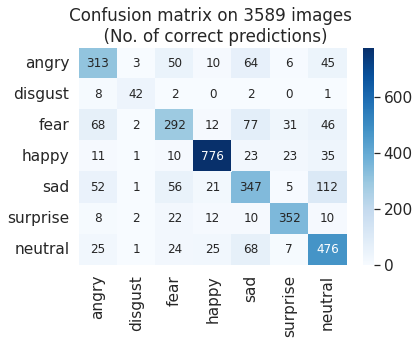

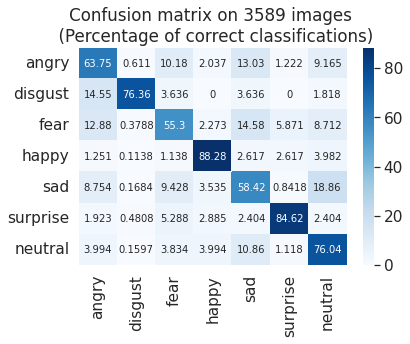



Accuracy of the network on the 3589 data: 72.39 %
72.38785176929507


In [72]:
m1 = FiveLayer()
m1.load_weights('drive/MyDrive/Models/5blocks_BatchNorm_0.1.pth')
res = m1.predict(x_test_input)
# dictionary[act] = draw_confusion_matrix(res,y_test)
print(draw_confusion_matrix(res,y_test))

In [ ]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/computationalcore/introduction-to-opencv/master/assets/haarcascade_frontalface_default.xml \
    -O haarcascade_frontalface_default.xml

--2022-04-25 23:13:03--  https://raw.githubusercontent.com/computationalcore/introduction-to-opencv/master/assets/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930127 (908K) [text/plain]
Saving to: ‘haarcascade_frontalface_default.xml’

haarcascade_frontal 100%[===================>] 908.33K  --.-KB/s    in 0.02s   

2022-04-25 23:13:03 (52.8 MB/s) - ‘haarcascade_frontalface_default.xml’ saved [930127/930127]



In [ ]:
dictionary = {
    0:'angry',
    1:'disgust',
    2:'fear',
    3:'happy',
    4:'sad',
    5:'surprise',
    6:'neutral'
}

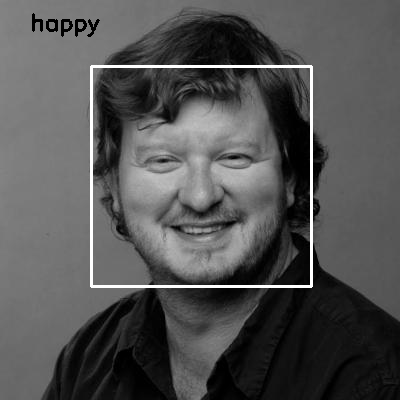

happy


In [ ]:
import cv2
im = cv2.imread('hpb.jpg',cv2.IMREAD_GRAYSCALE)
# cv2_imshow(im)

face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
faces = face_cascade.detectMultiScale(im, 1.3, 5)
crop = []
for (x,y,w,h) in faces:
     cv2.rectangle(im,(x,y),(x+w,y+h),(255,0,0),2)
     crop = im[ y:y+h,x:x+w]
     t = tf.expand_dims(crop,0)
     t = tf.expand_dims(t,-1)
     res = m1.predict(t)
     cv2.putText(im, dictionary[np.argmax(res)],
                        (30, 30 ), cv2.FONT_HERSHEY_SIMPLEX, 0.75,
                        (0,0,0), 2)

from google.colab.patches import cv2_imshow
cv2_imshow(im)
print(dictionary[np.argmax(res)])

In [ ]:
crop.shape

(304, 304)

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)
  
  return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

<IPython.core.display.Javascript object>

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data) 

  # import cv2
  # im = cv2.imread('photo.jpg',cv2.IMREAD_GRAYSCALE)
  face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
  faces = face_cascade.detectMultiScale(img, 1.1, 5)
  crop = []
  for (x,y,w,h) in faces:
      cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
      crop = img[ y:y+h,x:x+w]
      t = tf.expand_dims(crop,0)
      t = tf.expand_dims(t,-1)
      res = m1.predict(t)
      cv2.putText(img, dictionary[np.argmax(res)],
                        (30, 30 ), cv2.FONT_HERSHEY_SIMPLEX, 0.75,
                        (0,0,0), 2)

  from google.colab.patches import cv2_imshow
  # cv2_imshow(img)
  print(dictionary[np.argmax(res)])
  
  # # call our darknet helper on webcam image
  # detections, width_ratio, height_ratio = darknet_helper(img, width, height)

  # # loop through detections and draw them on webcam image
  # for label, confidence, bbox in detections:
  #   left, top, right, bottom = bbox2points(bbox)
  #   left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
  #   cv2.rectangle(img, (left, top), (right, bottom), class_colors[label], 2)
  #   cv2.putText(img, dictionary[np.argmax(res)],
  #                     (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
  #                     (255,0,0), 2)
  # save image
  cv2.imwrite(filename, img)

  return filename

<IPython.core.display.Javascript object>

sad
Saved to photo.jpg


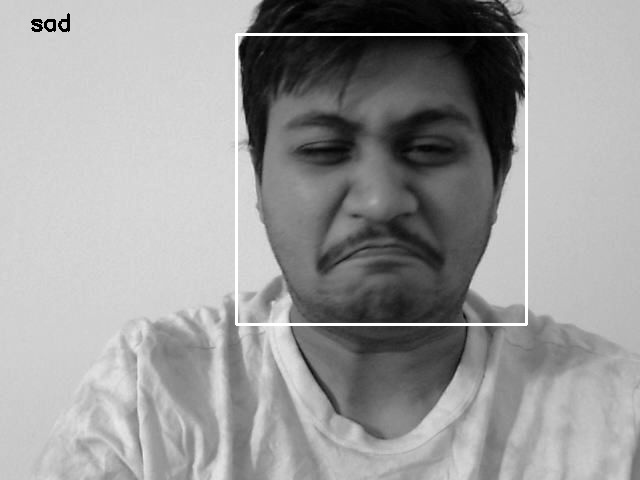

In [ ]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
res

array([[7.0857401e-05, 2.4690089e-06, 1.2157364e-03, ..., 6.8679184e-01,
        6.9340551e-04, 3.1094295e-01],
       [7.5177602e-05, 2.5274148e-06, 6.5504096e-04, ..., 4.8708436e-01,
        9.5527200e-04, 5.1090622e-01],
       [6.2257663e-05, 1.2105953e-06, 1.5045657e-04, ..., 2.5293332e-01,
        1.3571842e-04, 7.4637848e-01],
       ...,
       [8.6815089e-01, 3.1752893e-07, 4.1965866e-03, ..., 2.7894853e-02,
        6.7409106e-02, 3.2191928e-02],
       [8.9508772e-01, 2.0227482e-07, 8.5645337e-03, ..., 3.5730451e-02,
        4.1220959e-02, 1.9333184e-02],
       [8.8388699e-01, 3.8380142e-07, 8.3392616e-03, ..., 5.0049681e-02,
        3.9395984e-02, 1.8277699e-02]], dtype=float32)

AttributeError: ignored

In [ ]:
im

array([[91, 91, 92, ..., 90, 91, 91],
       [91, 92, 93, ..., 88, 89, 89],
       [92, 92, 93, ..., 84, 85, 86],
       ...,
       [95, 95, 96, ..., 92, 92, 92],
       [94, 94, 95, ..., 91, 90, 90],
       [93, 93, 94, ..., 90, 89, 89]], dtype=uint8)

In [ ]:
t = tf.expand_dims(crop,0)

In [ ]:
t.shape

TensorShape([1, 310, 310])

In [ ]:
t = tf.expand_dims(t,-1)

In [ ]:
res = m1.predict(t)

In [ ]:
res

array([[6.4888130e-09, 1.5033374e-11, 4.7789324e-09, 9.9999750e-01,
        1.4666095e-11, 6.5863905e-11, 2.4699523e-06]], dtype=float32)

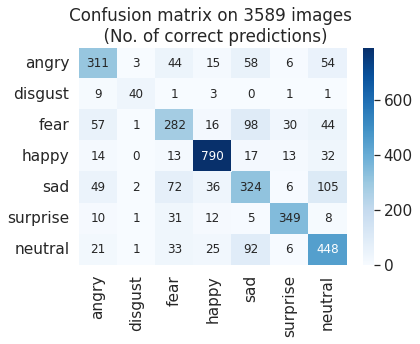

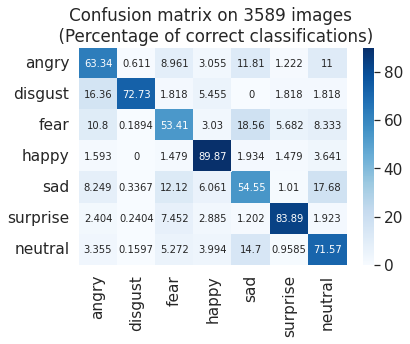



Accuracy of the network on the 3589 data: 70.88 %
70.88325438840903


In [16]:
m2 = FiveLayer()
m2.load_weights('drive/MyDrive/Models/5Block_SMOTETomek.pth')
res = m2.predict(x_test_input)
# dictionary[act] = draw_confusion_matrix(res,y_test)
print(draw_confusion_matrix(res,y_test))

In [77]:
from sklearn.metrics import classification_report
y_pred = np.argmax(res, axis=1)
y_true = np.argmax(y_test, axis=1)

classes = ['angry','disgust','fear','happy','sad','surprise','neutral']
print(classification_report(y_true, y_pred, target_names=classes))

              precision    recall  f1-score   support

       angry       0.65      0.64      0.64       491
     disgust       0.81      0.76      0.79        55
        fear       0.64      0.55      0.59       528
       happy       0.91      0.88      0.89       879
         sad       0.59      0.58      0.59       594
    surprise       0.83      0.85      0.84       416
     neutral       0.66      0.76      0.70       626

    accuracy                           0.72      3589
   macro avg       0.72      0.72      0.72      3589
weighted avg       0.72      0.72      0.72      3589



In [78]:
indices = np.argpartition(res, -2, axis=1)[:, -2:]
correct = 0
for i in range(3589):
  if(np.argmax(y_test[i]) in indices[i]):
    correct+=1
print(correct/3589)

0.8590136528280858


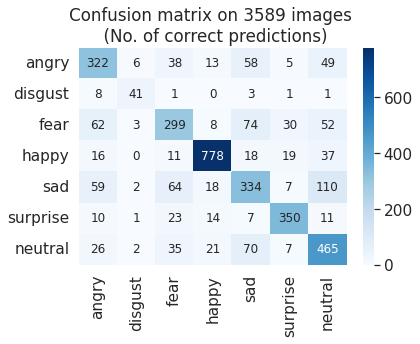

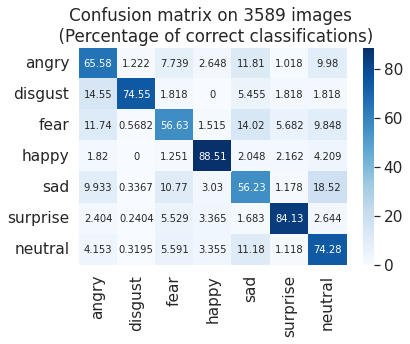



Accuracy of the network on the 3589 data: 72.14 %
72.13708553914739


In [30]:
m3 = FiveLayer()
m3.load_weights('drive/MyDrive/Models/5blocks_BatchNorm_0.2.pth')
res = m3.predict(x_test_input)
# dictionary[act] = draw_confusion_matrix(res,y_test)
print(draw_confusion_matrix(res,y_test))

In [ ]:
def get_saliency_map(model, image, class_idx):
    with tf.GradientTape() as tape:
        tape.watch(image)
        predictions = model(image)
        
        loss = predictions[:, class_idx]
    
    # Get the gradients of the loss w.r.t to the input image.
    gradient = tape.gradient(loss, image)
    
    # take maximum across channels
    gradient = tf.reduce_max(gradient, axis=-1)
    
    # convert to numpy
    gradient = gradient.numpy()
    
    # normaliz between 0 and 1
    min_val, max_val = np.min(gradient), np.max(gradient)
    smap = (gradient - min_val) / (max_val - min_val + keras.backend.epsilon())
    
    return smap

In [ ]:
m4 = FiveLayer()
m4.load_weights('drive/MyDrive/Models/5blocks_week1_lr3.pth')
res = m4.predict(x_test_input)
# dictionary[act] = draw_confusion_matrix(res,y_test)
print(draw_confusion_matrix(res,y_test))

In [31]:
from keras.regularizers import L2
# from tf.keras import layers


def FourLayer(dropout=0.25,activation = 'relu',final_activation = 'softmax',lr = 0.001,opt = 'adam'):
  # tf.keras.mixed_precision.set_global_policy('mixed_float16')
  test_model1 = Sequential()
  # Block 1
  
  test_model1.add(tf.keras.layers.Resizing(72,72))
  test_model1.add(OcclusionLayer())
  test_model1.add(tf.keras.layers.Rescaling(1./255))
  test_model1.add(tf.keras.layers.RandomTranslation(0.1,0.1))
  test_model1.add(tf.keras.layers.RandomRotation(0.027))
  test_model1.add(tf.keras.layers.RandomFlip(mode="horizontal"))
  test_model1.add(tf.keras.layers.BatchNormalization())
  
  # test_model1.add(tf.keras.layers.RandomContrast(0.1))
  # test_model1.add(tf.keras.layers.CenterCrop(1./255))
  # test_model1.add(tf.keras.layers.RandomTranslation(0.1,0.1))
  # test_model1.add(tf.keras.layers.RandomRotation(0.027))
  # test_model1.add(tf.keras.layers.RandomFlip(mode="horizontal"))
  

  
  # test_model1.add(tf.keras.layers.Normalization(input_shape=(48,48,1)))
  test_model1.add(Convolution2D(64, (3, 3), padding='same'))
  test_model1.add(Convolution2D(64, (3, 3), padding='same'))
  # Batch normalization before activation
  test_model1.add(BatchNormalization())
  test_model1.add(Activation(activation))
  test_model1.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  # Dropout at the end of the block
  test_model1.add(Dropout(dropout))

  # Block 2
  test_model1.add(Convolution2D(128, (3, 3), padding='same'))
  test_model1.add(Convolution2D(128, (3, 3), padding='same'))
  test_model1.add(BatchNormalization())
  test_model1.add(Activation(activation))
  test_model1.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  test_model1.add(Dropout(dropout))

  # Block 3
  test_model1.add(Convolution2D(256, (3, 3), padding='same'))
  test_model1.add(Convolution2D(256, (3, 3), padding='same'))
  test_model1.add(BatchNormalization())
  test_model1.add(Activation(activation))
  test_model1.add(MaxPooling2D(pool_size=(3, 3), strides=None, padding='same'))
  test_model1.add(Dropout(dropout))

  # # Block 6
  # test_model1.add(Convolution2D(256, (3, 3), padding='same'))
  # test_model1.add(Convolution2D(256, (3, 3), padding='same'))
  # test_model1.add(BatchNormalization())
  # test_model1.add(Activation(activation))
  # test_model1.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  # test_model1.add(Dropout(dropout))


  # Block 4
  test_model1.add(Convolution2D(512, (3, 3), padding='same'))
  test_model1.add(Convolution2D(512, (3, 3), padding='same'))
  test_model1.add(BatchNormalization())
  test_model1.add(Activation(activation))
  test_model1.add(MaxPooling2D(pool_size=(6, 6), strides=None, padding='same'))
  test_model1.add(Dropout(dropout))

  # # Block 5
  # test_model1.add(Convolution2D(512, (3, 3), padding='same'))
  # test_model1.add(Convolution2D(512, (3, 3), padding='same'))
  # test_model1.add(BatchNormalization())
  # test_model1.add(Activation(activation))
  # test_model1.add(MaxPooling2D(pool_size=(3, 3), strides=None, padding='same'))
  # test_model1.add(Dropout(dropout))

  
  #Flatten
  test_model1.add(Flatten())
  

  test_model1.add(Dense(2048))
  test_model1.add(BatchNormalization())
  test_model1.add(Activation(activation))
  test_model1.add(Dropout(dropout))

  test_model1.add(Dense(512))
  test_model1.add(BatchNormalization())
  test_model1.add(Activation(activation))
  test_model1.add(Dropout(dropout))

  # test_model1.add(Dense(128))
  # test_model1.add(BatchNormalization())
  # test_model1.add(Activation(activation))
  # test_model1.add(Dropout(dropout))

  test_model1.add(Dense(7))
  test_model1.add(Activation(final_activation))

  adamax = tf.keras.optimizers.Adam(
      learning_rate=lr,
      beta_1=0.9,
      beta_2=0.999,
      epsilon=1e-07,
      amsgrad=False,
      name="Adam"
  )

  test_model1.compile(loss='categorical_crossentropy', optimizer = adamax, metrics=['accuracy'])

  return test_model1



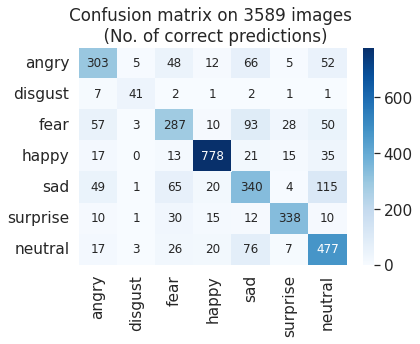

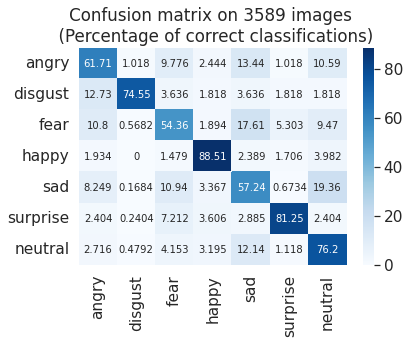



Accuracy of the network on the 3589 data: 71.44 %
71.44051267762607


In [34]:
m8 = FourLayer()
m8.load_weights('drive/MyDrive/Models/4Blocks_BatchNorm_0.2.pth').expect_partial()
res = m8.predict(x_test_input)
# dictionary[act] = draw_confusion_matrix(res,y_test)
print(draw_confusion_matrix(res,y_test))


In [35]:
from keras.regularizers import L2
# from tf.keras import layers


def SixLayer(dropout=0.25,activation = 'relu',final_activation = 'softmax',lr = 0.001,opt = 'adam'):
  # tf.keras.mixed_precision.set_global_policy('mixed_float16')
  test_model1 = Sequential()
  # Block 1
  
  test_model1.add(tf.keras.layers.Resizing(72,72))
  test_model1.add(OcclusionLayer())
  test_model1.add(tf.keras.layers.Rescaling(1./255))
  test_model1.add(tf.keras.layers.RandomTranslation(0.1,0.1))
  test_model1.add(tf.keras.layers.RandomRotation(0.027))
  test_model1.add(tf.keras.layers.RandomFlip(mode="horizontal"))
  test_model1.add(tf.keras.layers.BatchNormalization())
  # test_model1.add(tf.keras.layers.RandomContrast(0.1))
  # test_model1.add(tf.keras.layers.CenterCrop(1./255))
  # test_model1.add(tf.keras.layers.RandomTranslation(0.1,0.1))
  # test_model1.add(tf.keras.layers.RandomRotation(0.027))
  # test_model1.add(tf.keras.layers.RandomFlip(mode="horizontal"))
  

  
  # test_model1.add(tf.keras.layers.Normalization(input_shape=(48,48,1)))
  test_model1.add(Convolution2D(64, (3, 3), padding='same'))
  test_model1.add(Convolution2D(64, (3, 3), padding='same'))
  # Batch normalization before activation
  test_model1.add(BatchNormalization())
  test_model1.add(Activation(activation))
  test_model1.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  # Dropout at the end of the block
  test_model1.add(Dropout(dropout))

  # Block 2
  test_model1.add(Convolution2D(128, (3, 3), padding='same'))
  test_model1.add(Convolution2D(128, (3, 3), padding='same'))
  test_model1.add(BatchNormalization())
  test_model1.add(Activation(activation))
  test_model1.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  test_model1.add(Dropout(dropout))

  # Block 3
  test_model1.add(Convolution2D(256, (3, 3), padding='same'))
  test_model1.add(Convolution2D(256, (3, 3), padding='same'))
  test_model1.add(BatchNormalization())
  test_model1.add(Activation(activation))
  test_model1.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  test_model1.add(Dropout(dropout))

  # Block 6
  test_model1.add(Convolution2D(256, (3, 3), padding='same'))
  test_model1.add(Convolution2D(256, (3, 3), padding='same'))
  test_model1.add(BatchNormalization())
  test_model1.add(Activation(activation))
  test_model1.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  test_model1.add(Dropout(dropout))


  # Block 4
  test_model1.add(Convolution2D(512, (3, 3), padding='same'))
  test_model1.add(Convolution2D(512, (3, 3), padding='same'))
  test_model1.add(BatchNormalization())
  test_model1.add(Activation(activation))
  test_model1.add(MaxPooling2D(pool_size=(3, 3), strides=None, padding='same'))
  test_model1.add(Dropout(dropout))

  # Block 5
  test_model1.add(Convolution2D(512, (3, 3), padding='same'))
  test_model1.add(Convolution2D(512, (3, 3), padding='same'))
  test_model1.add(BatchNormalization())
  test_model1.add(Activation(activation))
  test_model1.add(MaxPooling2D(pool_size=(3, 3), strides=None, padding='same'))
  test_model1.add(Dropout(dropout))

  
  #Flatten
  test_model1.add(Flatten())
  

  test_model1.add(Dense(2048))
  test_model1.add(BatchNormalization())
  test_model1.add(Activation(activation))
  test_model1.add(Dropout(dropout))

  test_model1.add(Dense(512))
  test_model1.add(BatchNormalization())
  test_model1.add(Activation(activation))
  test_model1.add(Dropout(dropout))

  # test_model1.add(Dense(128))
  # test_model1.add(BatchNormalization())
  # test_model1.add(Activation(activation))
  # test_model1.add(Dropout(dropout))

  test_model1.add(Dense(7))
  test_model1.add(Activation(final_activation))

  adamax = tf.keras.optimizers.Adam(
      learning_rate=lr,
      beta_1=0.9,
      beta_2=0.999,
      epsilon=1e-07,
      amsgrad=False,
      name="Adam"
  )

  test_model1.compile(loss='categorical_crossentropy', optimizer = adamax, metrics=['accuracy'])

  return test_model1



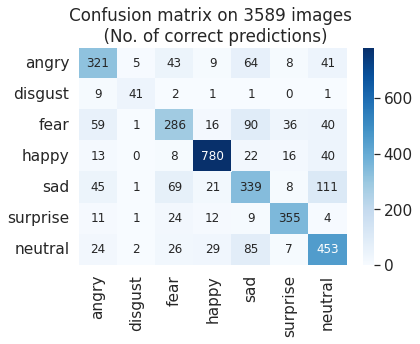

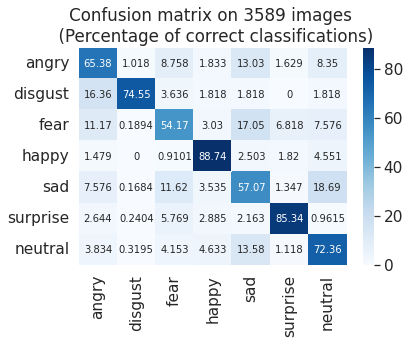



Accuracy of the network on the 3589 data: 71.75 %
71.74700473669546


In [36]:
m10 = SixLayer()
m10.load_weights('drive/MyDrive/Models/6blocks_BatchNorm2_0.15.pth')
res = m10.predict(x_test_input)
# dictionary[act] = draw_confusion_matrix(res,y_test)
print(draw_confusion_matrix(res,y_test))


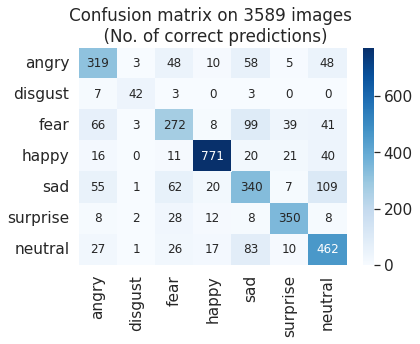

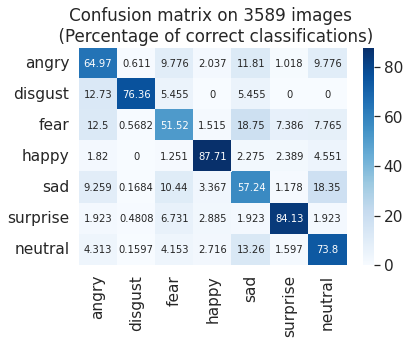



Accuracy of the network on the 3589 data: 71.22 %
71.21760936193925


In [ ]:
m11 = SixLayer2()
m11.load_weights('drive/MyDrive/Models/6blocks_week1_lr34.pth')
res = m11.predict(x_test_input)
# dictionary[act] = draw_confusion_matrix(res,y_test)
print(draw_confusion_matrix(res,y_test))

3 channel

In [37]:
# n_train = int(len(X_train))
n_valid = int(len(x_valid_matrix))
n_test = int(len(x_test_matrix))

#Convert to 3 channels for these architectures
# x_train_input = np.empty([n_train, 48, 48, 1])
# for index, item in enumerate(x_train_input):
#     item[:, :, 0] = X_train[index]
#     # gray = cv2.cvtColor(X_train[index], cv2.COLOR_RGB2GRAY)
#     # gray = X_train[index].astype(np.uint16)
#     # eq = clahe.apply(gray)
#     # item[:, :, 0] = eq

# x_valid_input = np.empty([n_valid, 48, 48, 1])
# for index, item in enumerate(x_valid_input):
#     item[:, :, 0] = x_valid_matrix[index]

x_test_input_3 = np.empty([n_test, 48, 48, 3])
for index, item in enumerate(x_test_input_3):
    item[:, :, 0] = x_test_matrix[index]
    item[:, :, 1] = x_test_matrix[index]
    item[:, :, 2] = x_test_matrix[index]


In [ ]:
class OcclusionLayerThree(tf.keras.layers.Layer):
  def __init__(self):
      super(OcclusionLayerThree, self).__init__()

  def call(self, tensor):
    if random.randint(1,2) == 1 or len(tensor.shape.as_list())!=4 or None in tensor.shape.as_list():
      return tensor
    shape = tensor.shape.as_list()[1:3]
    center_x = (int)(shape[0]/2)
    center_y = (int)(shape[1]/2)
    x = random.randint(1,center_x)
    y = random.randint(1,center_y)
    l = random.randint(2,(int)(center_x/2))
    b = random.randint(2,(int)(center_y/2))
    m = np.ones(tensor.shape)
    m[:,(int)(x-l/2):(int)(x+l/2),(int)(y-b/2):(int)(y+b/2),0] = 0
    m[:,(int)(x-l/2):(int)(x+l/2),(int)(y-b/2):(int)(y+b/2),1] = 0
    m[:,(int)(x-l/2):(int)(x+l/2),(int)(y-b/2):(int)(y+b/2),2] = 0
    return tf.multiply(tensor,tf.convert_to_tensor(m,dtype=tensor.dtype))

In [38]:
from keras.regularizers import L2
# from tf.keras import layers

from keras.applications.vgg16 import VGG16
# vgg16_model = tf.keras.applications.vgg16.VGG16()



def test_vgg16(dropout=0.25,activation = 'relu',final_activation = 'softmax',lr = 0.001,opt = 'adam'):
  # tf.keras.mixed_precision.set_global_policy('mixed_float16')
  inputs = keras.Input(shape=(48, 48, 3))
  test_model1 = Sequential()
  # Block 1
  
  test_model1.add(tf.keras.layers.Resizing(72,72))
  test_model1.add(OcclusionLayerThree())
  test_model1.add(tf.keras.layers.Rescaling(1./255))
  test_model1.add(tf.keras.layers.RandomTranslation(0.1,0.1))
  test_model1.add(tf.keras.layers.RandomRotation(0.027))
  test_model1.add(tf.keras.layers.RandomFlip(mode="horizontal"))
  test_model1.add(tf.keras.layers.BatchNormalization())


  # output1 = test_model1(inputs)
  # res_output = vgg16(output1)
  
  vgg16 = VGG16(include_top=False, input_shape=(72, 72, 3), weights='imagenet')
  for layer in vgg16.layers[:-1]:
    test_model1.add(layer)
  # Flatten
  

  # for layer in test_model1.layers:
  #   layer.trainable = False
  
  # test_model2 = Sequential()
  test_model1.add(Flatten())

  test_model1.add(Dense(2048))
  test_model1.add(BatchNormalization())
  test_model1.add(Activation(activation))
  test_model1.add(Dropout(dropout))

  test_model1.add(Dense(512))
  test_model1.add(BatchNormalization())
  test_model1.add(Activation(activation))
  test_model1.add(Dropout(dropout))

  # test_model1.add(Dense(128))
  # test_model1.add(BatchNormalization())
  # test_model1.add(Activation(activation))
  # test_model1.add(Dropout(dropout))

  test_model1.add(Dense(7))
  test_model1.add(Activation(final_activation))

  # f_out = test_model2(res_output)
  # final_model2 = Model(inputs=inputs, outputs=f_out)


  # test_model1.compile(loss='categorical_crossentropy', metrics=['accuracy'])

  return test_model1

In [ ]:
model = test_vgg16(dropout=0.1,lr = 0.0001,activation='relu')
model.load_weights('drive/MyDrive/Models/VGG16_finale_0.1.pth').expect_partial()
# new_model = tf.keras.models.load_weights('drive/MyDrive/Models/VGG19_BatchNorm_0.3.pth')
new_model.build((None,48,48,3))
new_model.summary()

ValueError: ignored

58900480/58889256 [==============================] - 1s 0us/step


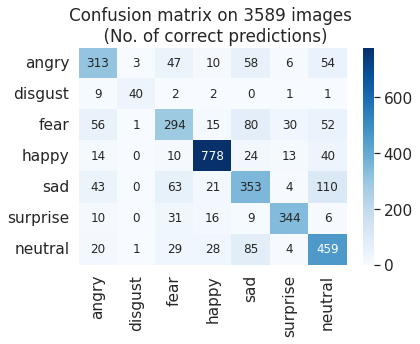

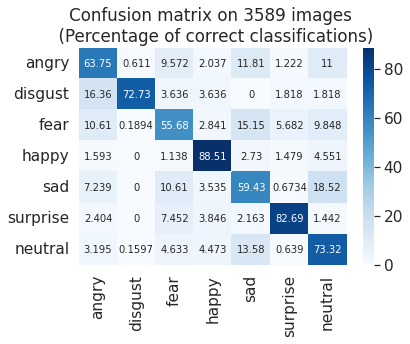



Accuracy of the network on the 3589 data: 71.91 %
71.91418222346057


In [39]:
m21 = test_vgg16(dropout=0.25,lr = 0.0001,activation='relu')
m21 = keras.models.load_model('drive/MyDrive/Models/VGG16_finale_0.1.pth')
res = m21.predict(x_test_input_3)
# dictionary[act] = draw_confusion_matrix(res,y_test)
print(draw_confusion_matrix(res,y_test))

In [40]:
from keras.regularizers import L2
# from tf.keras import layers

from keras.applications.vgg19 import VGG19
# vgg16_model = tf.keras.applications.vgg16.VGG16()



def test_vgg19(dropout=0.25,activation = 'relu',final_activation = 'softmax',lr = 0.001,opt = 'adam'):
  # tf.keras.mixed_precision.set_global_policy('mixed_float16')
  inputs = keras.Input(shape=(48, 48, 3))
  test_model1 = Sequential()
  # Block 1
  
  test_model1.add(tf.keras.layers.Resizing(72,72))
  test_model1.add(OcclusionLayerThree())
  test_model1.add(tf.keras.layers.Rescaling(1./255))
  test_model1.add(tf.keras.layers.RandomTranslation(0.1,0.1))
  test_model1.add(tf.keras.layers.RandomRotation(0.027))
  test_model1.add(tf.keras.layers.RandomFlip(mode="horizontal"))
  test_model1.add(tf.keras.layers.BatchNormalization())


  # output1 = test_model1(inputs)
  # res_output = vgg16(output1)
  
  vgg19 = VGG19(include_top=False, input_shape=(72, 72, 3))
  for layer in vgg19.layers[:-1]:
    test_model1.add(layer)
  # Flatten
  

  # for layer in test_model1.layers:
  #   layer.trainable = False
  
  # test_model2 = Sequential()
  test_model1.add(Flatten())

  test_model1.add(Dense(2048))
  test_model1.add(BatchNormalization())
  test_model1.add(Activation(activation))
  test_model1.add(Dropout(dropout))

  test_model1.add(Dense(512))
  test_model1.add(BatchNormalization())
  test_model1.add(Activation(activation))
  test_model1.add(Dropout(dropout))

  # test_model1.add(Dense(128))
  # test_model1.add(BatchNormalization())
  # test_model1.add(Activation(activation))
  # test_model1.add(Dropout(dropout))

  test_model1.add(Dense(7))
  test_model1.add(Activation(final_activation))

  # f_out = test_model2(res_output)
  # final_model2 = Model(inputs=inputs, outputs=f_out)

  adamax = tf.keras.optimizers.Adam(
      learning_rate=lr,
      beta_1=0.9,
      beta_2=0.999,
      epsilon=1e-07,
      amsgrad=False,
      name="Adam"
  )

  test_model1.compile(loss='categorical_crossentropy', optimizer = adamax, metrics=['accuracy'])

  return test_model1

80150528/80134624 [==============================] - 1s 0us/step


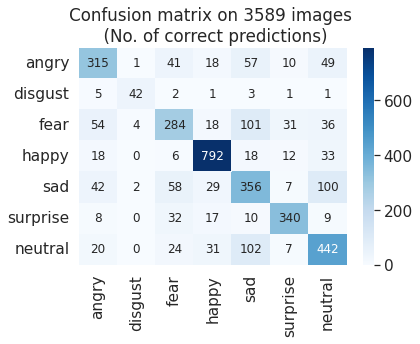

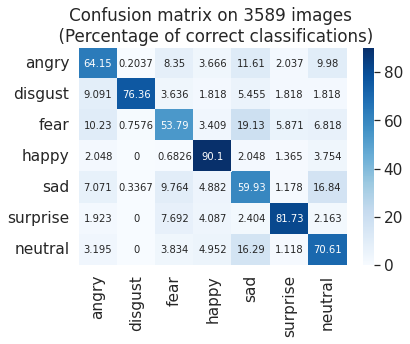



Accuracy of the network on the 3589 data: 71.64 %
71.63555307885204


In [41]:
m22 = test_vgg19()
m22= keras.models.load_model('drive/MyDrive/Models/VGG19_finale2_0.25.pth')
res = m22.predict(x_test_input_3)
# dictionary[act] = draw_confusion_matrix(res,y_test)
print(draw_confusion_matrix(res,y_test))

In [42]:

from keras.applications.resnet import ResNet50
# vgg16_model = tf.keras.applications.vgg16.VGG16()
resnet = ResNet50(include_top=False, input_shape=(72, 72, 3), weights='imagenet')

94781440/94765736 [==============================] - 1s 0us/step


In [43]:
from keras.regularizers import L2
# from tf.keras import layers



def test_resnet(dropout=0.25,activation = 'relu',final_activation = 'softmax',lr = 0.001,opt = 'adam'):
  # tf.keras.mixed_precision.set_global_policy('mixed_float16')
  inputs = keras.Input(shape=(48, 48, 3))
  test_model1 = Sequential()
  # Block 1
  
  test_model1.add(tf.keras.layers.Resizing(72,72))
  test_model1.add(OcclusionLayerThree())
  test_model1.add(tf.keras.layers.Rescaling(1./255))
  test_model1.add(tf.keras.layers.RandomTranslation(0.1,0.1))
  test_model1.add(tf.keras.layers.RandomRotation(0.027))
  test_model1.add(tf.keras.layers.RandomFlip(mode="horizontal"))
  test_model1.add(tf.keras.layers.BatchNormalization())


  output1 = test_model1(inputs)
  res_output = resnet(output1)
  

  # for layer in vgg16.layers[:-1]:
  #   test_model1.add(layer)
  #Flatten
  

  # for layer in test_model1.layers:
  #   layer.trainable = False
  
  test_model2 = Sequential()
  test_model2.add(Flatten())

  test_model2.add(Dense(2048))
  test_model2.add(BatchNormalization())
  test_model2.add(Activation(activation))
  test_model2.add(Dropout(dropout))

  test_model2.add(Dense(512))
  test_model2.add(BatchNormalization())
  test_model2.add(Activation(activation))
  test_model2.add(Dropout(dropout))

  # test_model1.add(Dense(128))
  # test_model1.add(BatchNormalization())
  # test_model1.add(Activation(activation))
  # test_model1.add(Dropout(dropout))

  test_model2.add(Dense(7))
  test_model2.add(Activation(final_activation))

  f_out = test_model2(res_output)
  final_model2 = Model(inputs=inputs, outputs=f_out)

  final_model2.compile(loss='categorical_crossentropy', metrics=['accuracy'])

  return final_model2

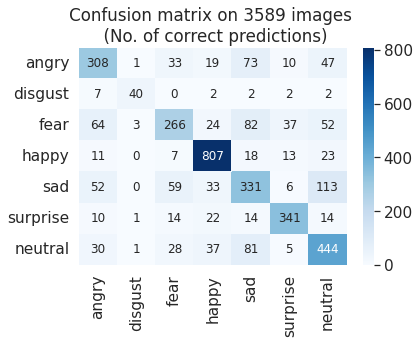

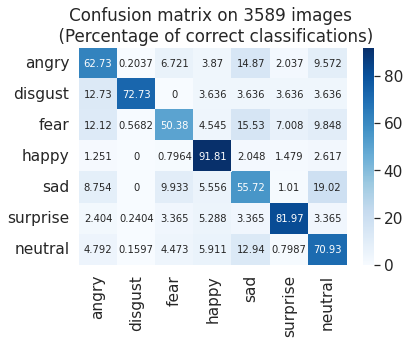



Accuracy of the network on the 3589 data: 70.69 %
70.68821398718306


In [44]:
m23 = test_resnet()
m23.load_weights('drive/MyDrive/Models/ResNet_BatchNorm2_0.2.pth')
res = m23.predict(x_test_input_3)
# dictionary[act] = draw_confusion_matrix(res,y_test)
print(draw_confusion_matrix(res,y_test))

In [45]:
from keras.applications.inception_v3 import InceptionV3
# vgg16_model = tf.keras.applications.vgg16.VGG16()
iv3 = InceptionV3(include_top=False, input_shape=(75, 75, 3), weights='imagenet')

87924736/87910968 [==============================] - 1s 0us/step


In [46]:
from keras.regularizers import L2
# from tf.keras import layers




def test_iv3(dropout=0.25,activation = 'relu',final_activation = 'softmax',lr = 0.001,opt = 'adam'):
  # tf.keras.mixed_precision.set_global_policy('mixed_float16')
  inputs = keras.Input(shape=(48, 48, 3))
  test_model1 = Sequential()
  # Block 1
  
  test_model1.add(tf.keras.layers.Resizing(75,75))
  test_model1.add(OcclusionLayerThree())
  test_model1.add(tf.keras.layers.Rescaling(1./255))
  test_model1.add(tf.keras.layers.RandomTranslation(0.1,0.1))
  test_model1.add(tf.keras.layers.RandomRotation(0.027))
  test_model1.add(tf.keras.layers.RandomFlip(mode="horizontal"))
  test_model1.add(tf.keras.layers.BatchNormalization())

  output1 = test_model1(inputs)
  res_output = iv3(output1)
  

  # for layer in vgg16.layers[:-1]:
  #   test_model1.add(layer)
  #Flatten
  

  # for layer in test_model1.layers:
  #   layer.trainable = False
  
  test_model2 = Sequential()
  test_model2.add(Flatten())

  test_model2.add(Dense(2048))
  test_model2.add(BatchNormalization())
  test_model2.add(Activation(activation))
  test_model2.add(Dropout(dropout))

  test_model2.add(Dense(512))
  test_model2.add(BatchNormalization())
  test_model2.add(Activation(activation))
  test_model2.add(Dropout(dropout))

  # test_model1.add(Dense(128))
  # test_model1.add(BatchNormalization())
  # test_model1.add(Activation(activation))
  # test_model1.add(Dropout(dropout))

  test_model2.add(Dense(7))
  test_model2.add(Activation(final_activation))

  f_out = test_model2(res_output)
  final_model2 = Model(inputs=inputs, outputs=f_out)

  adamax = tf.keras.optimizers.Adam(
      learning_rate=lr,
      beta_1=0.9,
      beta_2=0.999,
      epsilon=1e-07,
      amsgrad=False,
      name="Adam"
  )

  final_model2.compile(loss='categorical_crossentropy', optimizer = adamax, metrics=['accuracy'])

  return final_model2

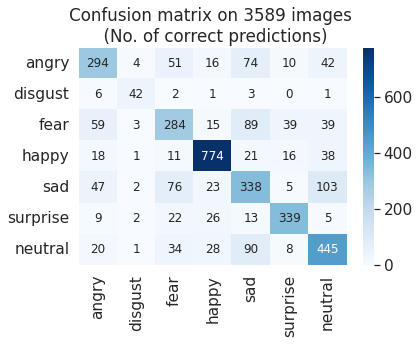

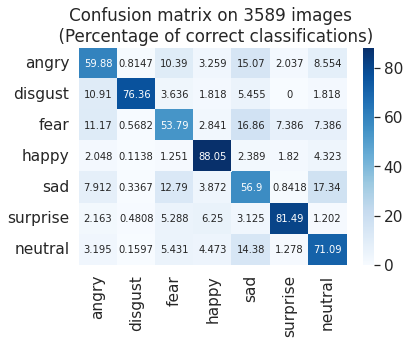



Accuracy of the network on the 3589 data: 70.10 %
70.10309278350515


In [47]:
m24 = test_iv3()
m24.load_weights('drive/MyDrive/Models/IV3_BatchNorm2_0.3.pth')
res = m24.predict(x_test_input_3)
# dictionary[act] = draw_confusion_matrix(res,y_test)
print(draw_confusion_matrix(res,y_test))

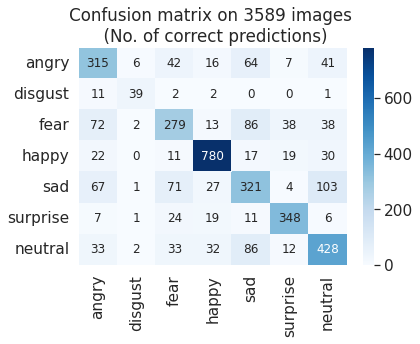

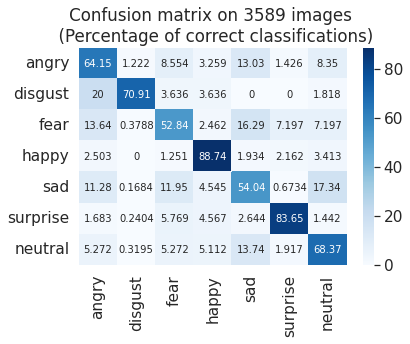



Accuracy of the network on the 3589 data: 69.94 %
69.93591529674003


In [48]:
m25 = test_iv3()
m25.load_weights('drive/MyDrive/Models/IV3_BatchNorm2_0.25.pth')
res = m25.predict(x_test_input_3)
# dictionary[act] = draw_confusion_matrix(res,y_test)
print(draw_confusion_matrix(res,y_test))

In [62]:
models = [m1,m3,m8,m10]

yhats = [model.predict(x_test_input) for model in models]
# yhats = np.array(yhats)# sum across ensembles
summed = np.sum(yhats, axis=0)
# summed = summed*0.85
# argmax across classes
outcomes = np.argmax(summed, axis=1)

In [67]:
models2 = [m21,m22,m23]

yhats = [model.predict(x_test_input_3) for model in models2]
# yhats = np.array(yhats)# sum across ensembles
summed2 = np.sum(yhats, axis=0)
# summed2 = summed2*2
# argmax across classes
outcomes = np.argmax(summed2, axis=1)

In [68]:
total_sum = np.sum([summed,summed2], axis=0)

In [69]:
indices = np.argpartition(total_sum, -2, axis=1)[:, -2:]
correct = 0
for i in range(3589):
  if(np.argmax(y_test[i]) in indices[i]):
    correct+=1
print('Top 2 accuracy: '+str(correct/3589))

Top 2 accuracy: 0.8813039843967679


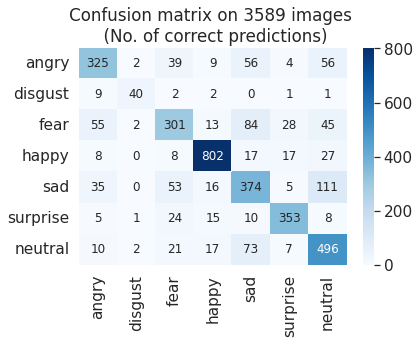

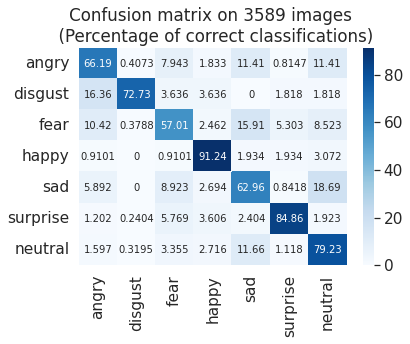



Accuracy of the network on the 3589 data: 74.98 %
74.97910281415436


In [70]:
print(draw_confusion_matrix(total_sum,y_test))

In [ ]:
from google.colab.patches import cv2_imshow
# import cv2_imshow

In [ ]:
dict = {}

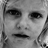

4 3


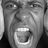

0 5


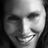

3 7


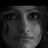

6 15


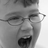

2 16


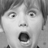

5 17


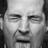

1 34


In [ ]:
s = [0,1,2,3,4,5,6]
for i in range(len(y_test)):
  if np.argmax(y_test[i]) == np.argmax(res[i]) and np.argmax(y_test[i]) in s:
    cv2_imshow(x_test_input[i])
    print(np.argmax(y_test[i]),i)
    s.remove(np.argmax(y_test[i]))

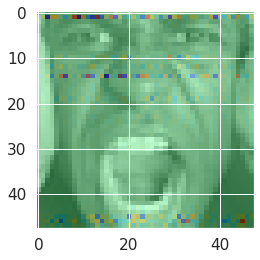

In [ ]:
im = x_test_input[5]
map = get_saliency_map(m10,tf.convert_to_tensor(im.astype('float64')),2)
plt.imshow(im[:,:,0], cmap='gray',interpolation='none') # I would add interpolation='none'

# Afterwards, you can easily overlay the segmentation by doing:

plt.imshow(map, cmap='jet', alpha=0.42,interpolation='none') # interpolation='none'


In [ ]:
map.shape

(48, 48)

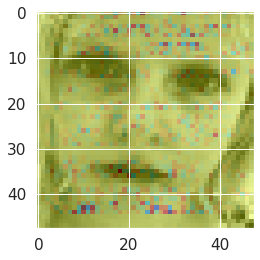

In [ ]:
plt.imshow(im[:,:,0], cmap='gray',interpolation='none') # I would add interpolation='none'

# Afterwards, you can easily overlay the segmentation by doing:

plt.imshow(map, cmap='jet', alpha=0.4,interpolation='none') # interpolation='none'


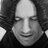

4 0


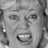

2 0


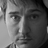

6 4


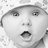

3 5


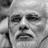

0 4


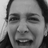

1 3


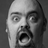

5 2


In [ ]:
s = [0,1,2,3,4,5,6]
for i in range(len(y_test)):
  if i < 1000:
    continue
  if np.argmax(y_test[i]) != np.argmax(res[i]) and np.argmax(y_test[i]) in s:
    cv2_imshow(x_test_input[i])
    print(np.argmax(y_test[i]),np.argmax(res[i]))
    s.remove(np.argmax(y_test[i]))

In [71]:
from sklearn.metrics import classification_report
y_pred = np.argmax(total_sum, axis=1)
y_true = np.argmax(y_test, axis=1)

classes = ['angry','disgust','fear','happy','sad','surprise','neutral']
print(classification_report(y_true, y_pred, target_names=classes))


              precision    recall  f1-score   support

       angry       0.73      0.66      0.69       491
     disgust       0.85      0.73      0.78        55
        fear       0.67      0.57      0.62       528
       happy       0.92      0.91      0.92       879
         sad       0.61      0.63      0.62       594
    surprise       0.85      0.85      0.85       416
     neutral       0.67      0.79      0.72       626

    accuracy                           0.75      3589
   macro avg       0.76      0.73      0.74      3589
weighted avg       0.75      0.75      0.75      3589



In [ ]:
model = SixLayer()
model.build((None,48,48,3))
model.summary()
del(model)

Model: "sequential_69"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_64 (Resizing)      (None, 72, 72, 3)         0         
                                                                 
 occlusion_layer_48 (Occlusi  (None, 72, 72, 3)        0         
 onLayer)                                                        
                                                                 
 rescaling_64 (Rescaling)    (None, 72, 72, 3)         0         
                                                                 
 random_translation_64 (Rand  (None, 72, 72, 3)        0         
 omTranslation)                                                  
                                                                 
 random_rotation_64 (RandomR  (None, 72, 72, 3)        0         
 otation)                                                        
                                                     